In [1]:
# import all needed libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection as fs

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [2]:
# load the cleaned dataset
clean_data = pd.read_csv(r'/Users/frederikbomheuer/Desktop/1.Semester/MachineLearing/Project/CO2/data/data_cleaned2.csv')


In [3]:
clean_data.head()

,country,year,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,mortality_rate_under_5,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc
0,Albania,2000,38.7,99.430855,0.467306,0.122940,41.751825,24.515412,1.031568,710.17,...,27.2,-63610.0,0.384636,7.821964,112.738212,69.454576,41.36,22.34,-2.147378,19.028
1,Albania,2001,41.0,99.421989,0.286160,0.060695,41.569343,22.716164,1.056868,686.38,...,25.8,-62059.0,0.375930,8.145374,111.685146,69.303040,39.04,18.38,-1.776391,18.575
2,Albania,2002,43.8,99.404579,0.296077,0.064922,41.605839,22.025114,1.233002,566.02,...,24.4,-59876.0,0.425487,8.508105,111.350730,69.232075,35.82,24.53,0.058111,17.895
3,Albania,2003,46.5,99.385628,0.312900,0.061352,40.912409,21.978257,1.361159,931.89,...,22.9,-57308.0,0.431772,8.899816,110.934890,69.876243,33.67,22.82,-0.869403,16.989
4,Albania,2004,49.2,99.372139,0.365360,0.052754,40.948905,20.537486,1.427944,554.96,...,21.5,-54383.0,0.420342,9.308444,110.472226,70.592238,35.84,17.91,-0.052818,16.310


In [4]:
# # Re-format the date column and set it as index
clean_data['year'] = pd.to_datetime(clean_data['year'], format='%Y')
# clean_data.set_index('year', inplace = True)
# clean_data.sort_index(inplace = True)

from sklearn.model_selection import TimeSeriesSplit 

tss = TimeSeriesSplit(n_splits=4)

clean_data.set_index('year', inplace=True)
clean_data.sort_index(inplace=True)

# Create lagged variables for CO2 emissions per capita
clean_data['co2_emissions_per_capita_lag1'] = clean_data.groupby('country')['co2_emissions_per_capita'].shift(1)
clean_data['co2_emissions_per_capita_lag2'] = clean_data.groupby('country')['co2_emissions_per_capita'].shift(2)

# Drop rows with NaN values created by lag features
clean_data.dropna(inplace=True)

X = clean_data.drop(labels=['co2_emissions_per_capita'], axis=1)
y = clean_data['co2_emissions_per_capita']

In [5]:
# train test split for a time series dataset
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [6]:
X_train.head()

,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,...,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1,co2_emissions_per_capita_lag2
year,,,,,,,,,,,,,,,,,,,,,
2002-01-01,Haiti,2.8,33.120686,0.397783,0.397783,60.595065,15.846504,4459.70,5.19,4.125,...,0.166158,3.749267,314.279608,83.171226,79.08,6.03,-0.785759,11.059,0.188035,0.176227
2002-01-01,Sudan,11.3,29.653931,4.579793,1.346549,55.813973,37.662742,6117.73,4.28,5.248,...,0.911334,2.437654,11.603669,40.362547,76.76,71.94,-1.440975,14.747,0.232118,0.216388
2002-01-01,Portugal,100.0,100.000000,0.117126,0.115519,42.379454,2.722891,599.85,3.37,1.460,...,0.357175,16.749770,113.875749,76.412641,18.28,4058.67,0.641944,4.500,5.923502,5.992401
2002-01-01,Burkina Faso,3.2,9.917558,0.027445,0.000000,37.869152,26.372448,6815.83,5.08,6.339,...,0.488140,2.855504,46.170574,76.520344,85.43,71.81,-2.026153,2.910,0.083612,0.088272
2002-01-01,"Venezuela, RB",97.3,99.800000,6.723990,0.000000,24.531489,3.847046,4592.82,8.11,2.739,...,0.486368,4.897160,28.718246,59.615121,12.84,1052.92,-1.389384,16.170,5.458171,5.383910


In [7]:
# Create dummy variables for each country
# data_with_dummies = pd.get_dummies(clean_data, columns=['country'], prefix='', prefix_sep='')


In [8]:
train_start = '2000-01-01'
train_end = '2016-01-01'

test_start = '2016-01-01'
test_end = '2020-01-01'

forecast_start = '2022-01-01'
forecast_end = '2026-01-01'

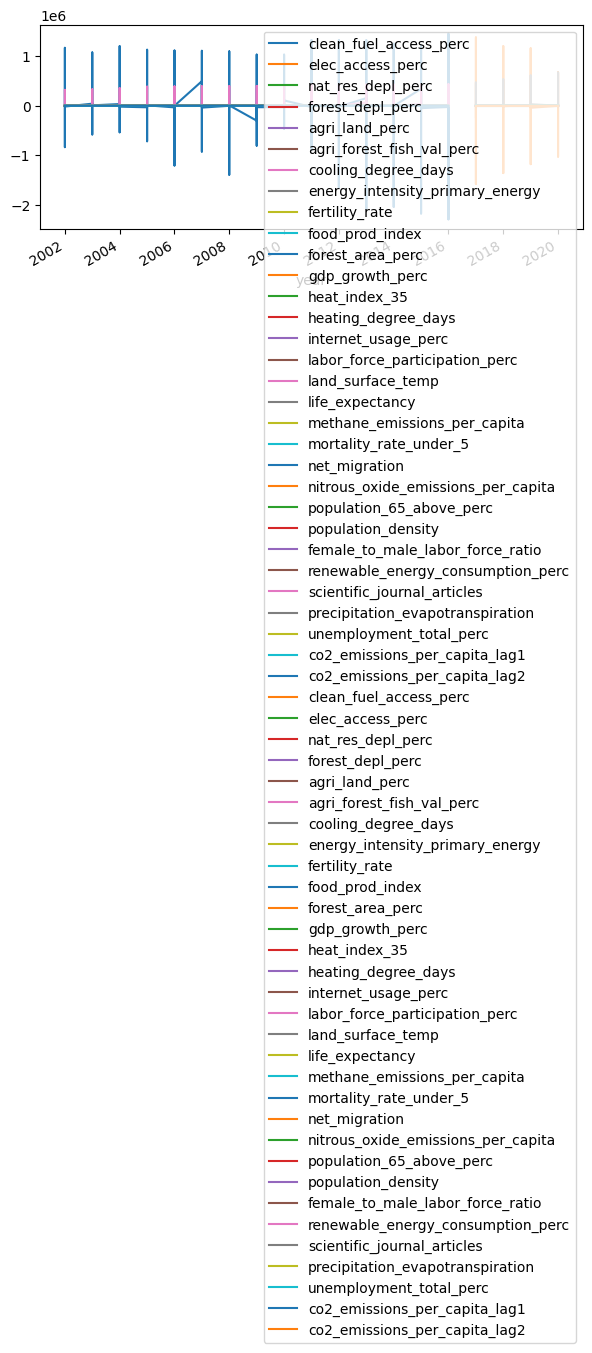

In [9]:
fig, ax = plt.subplots(figsize=(7, 3))
X_train.loc[train_start:train_end].plot(ax=ax, label = "Train")
X_test.loc[test_start:test_end].plot(ax=ax, label = "Test")
ax.legend()

Create Model


In [10]:
chosen_features = ['elec_access_perc', 'forest_depl_perc', 'agri_land_perc', 'cooling_degree_days', 'food_prod_index', 'forest_area_perc', 'internet_usage_perc', 'land_surface_temp', 'life_expectancy', 'methane_emissions_per_capita', 'renewable_energy_consumption_perc', 'precipitation_evapotranspiration', 'unemployment_total_perc', 'co2_emissions_per_capita_lag1']

features_train_reduced = X_train[chosen_features]
features_test_reduced = X_test[chosen_features]

In [11]:
import xgboost as xgb

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       )

reg.fit(features_train_reduced, y_train,
        eval_set=[(features_test_reduced, y_test), (features_train_reduced, y_train)],
        verbose=True)

[0]	validation_0-rmse:3.41100	validation_1-rmse:4.16695
[1]	validation_0-rmse:2.40363	validation_1-rmse:2.98096
[2]	validation_0-rmse:1.70992	validation_1-rmse:2.14583
[3]	validation_0-rmse:1.19453	validation_1-rmse:1.55953
[4]	validation_0-rmse:0.88875	validation_1-rmse:1.14890
[5]	validation_0-rmse:0.68249	validation_1-rmse:0.85688
[6]	validation_0-rmse:0.57055	validation_1-rmse:0.65731
[7]	validation_0-rmse:0.50983	validation_1-rmse:0.51342
[8]	validation_0-rmse:0.48959	validation_1-rmse:0.41411
[9]	validation_0-rmse:0.47786	validation_1-rmse:0.34753
[10]	validation_0-rmse:0.47051	validation_1-rmse:0.30114
[11]	validation_0-rmse:0.47196	validation_1-rmse:0.26878
[12]	validation_0-rmse:0.47383	validation_1-rmse:0.24874
[13]	validation_0-rmse:0.47598	validation_1-rmse:0.23295
[14]	validation_0-rmse:0.47726	validation_1-rmse:0.22110
[15]	validation_0-rmse:0.48219	validation_1-rmse:0.21001
[16]	validation_0-rmse:0.47853	validation_1-rmse:0.20166
[17]	validation_0-rmse:0.48040	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
feature_importances = pd.DataFrame(data=reg.feature_importances_,
                                   index=reg.feature_names_in_,
                                   columns=['importance'])

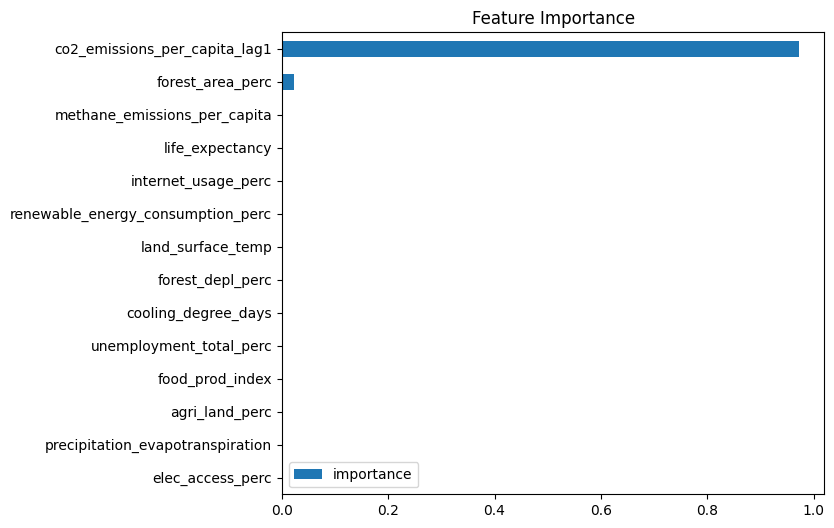

In [14]:
feature_importances.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(7, 6))
plt.show()

Forecast

In [15]:
features_test_reduced['prediction'] = reg.predict(features_test_reduced)

/var/folders/r2/8t4lt6m50fs6052zj19gbf1r0000gn/T/ipykernel_22969/2116596411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test_reduced['prediction'] = reg.predict(features_test_reduced)


In [16]:
features_test_reduced.tail()

,elec_access_perc,forest_depl_perc,agri_land_perc,cooling_degree_days,food_prod_index,forest_area_perc,internet_usage_perc,land_surface_temp,life_expectancy,methane_emissions_per_capita,renewable_energy_consumption_perc,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1,prediction
year,,,,,,,,,,,,,,,
2020-01-01,99.853111,0.174089,19.178439,404.33,102.84,61.486989,77.608793,15.563220,75.931707,1.260630,39.56,-0.992217,17.880,4.181645,4.380869
2020-01-01,99.502167,0.000000,72.358944,367.39,168.69,9.099658,65.630580,13.624713,72.141000,5.512313,3.98,-0.807138,6.590,7.160836,7.266912
2020-01-01,100.000000,0.000000,68.865061,877.28,81.46,11.753222,59.152949,21.344413,70.166000,1.247453,23.66,-1.724251,1.210,3.348667,3.396925
2020-01-01,89.900000,0.513311,28.747820,1393.38,120.46,41.590722,45.846159,21.375703,69.246000,0.805614,74.54,-0.198625,13.119,0.480725,0.528805
2020-01-01,52.747667,2.315889,41.876696,2640.14,110.34,45.093912,29.298565,32.436873,61.124000,0.769692,84.36,-0.204054,8.651,0.663338,0.847929


In [17]:
forecast_df = clean_data.merge(features_test_reduced[['prediction']], left_index=True, right_index=True, how='left')

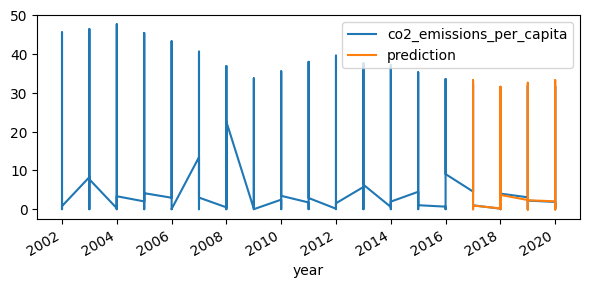

In [18]:
ax = forecast_df[['co2_emissions_per_capita', 'prediction']].plot(figsize=(7, 3))

-----

In [19]:
import pmdarima as pm

In [20]:
X_train.head()

,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,...,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc,co2_emissions_per_capita_lag1,co2_emissions_per_capita_lag2
year,,,,,,,,,,,,,,,,,,,,,
2002-01-01,Haiti,2.8,33.120686,0.397783,0.397783,60.595065,15.846504,4459.70,5.19,4.125,...,0.166158,3.749267,314.279608,83.171226,79.08,6.03,-0.785759,11.059,0.188035,0.176227
2002-01-01,Sudan,11.3,29.653931,4.579793,1.346549,55.813973,37.662742,6117.73,4.28,5.248,...,0.911334,2.437654,11.603669,40.362547,76.76,71.94,-1.440975,14.747,0.232118,0.216388
2002-01-01,Portugal,100.0,100.000000,0.117126,0.115519,42.379454,2.722891,599.85,3.37,1.460,...,0.357175,16.749770,113.875749,76.412641,18.28,4058.67,0.641944,4.500,5.923502,5.992401
2002-01-01,Burkina Faso,3.2,9.917558,0.027445,0.000000,37.869152,26.372448,6815.83,5.08,6.339,...,0.488140,2.855504,46.170574,76.520344,85.43,71.81,-2.026153,2.910,0.083612,0.088272
2002-01-01,"Venezuela, RB",97.3,99.800000,6.723990,0.000000,24.531489,3.847046,4592.82,8.11,2.739,...,0.486368,4.897160,28.718246,59.615121,12.84,1052.92,-1.389384,16.170,5.458171,5.383910


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Forecast: year
2017-01-01   NaN
2017-01-01   NaN
2017-01-01   NaN
2017-01-01   NaN
2017-01-01   NaN
              ..
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
Length: 608, dtype: float64


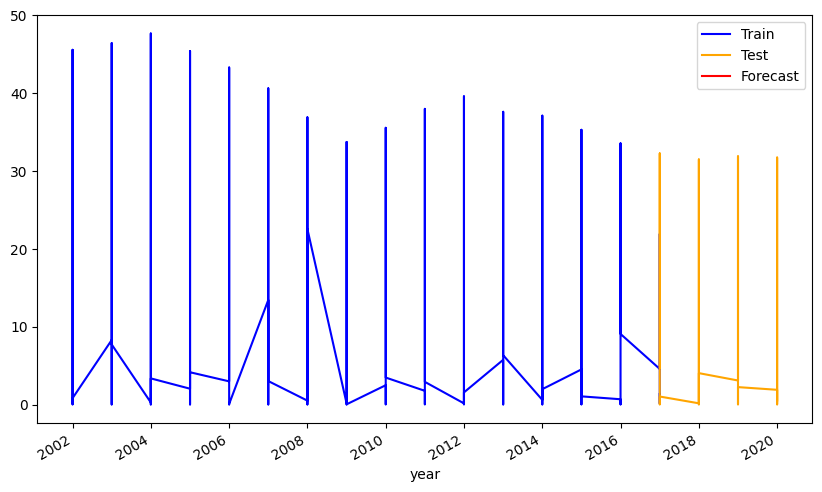

In [21]:
# Initialize and fit the AutoARIMA model
arima = pm.auto_arima(y_train, seasonal=False, stepwise=True)

# Forecast
forecast = arima.predict(n_periods=len(y_test))

# Convert predictions to pandas Series with the same index as the test data
forecast = pd.Series(forecast, index=y_test.index)

# Print the forecasted values
print("ARIMA Forecast:", forecast)

# Plot the actual test data and the forecast
fig, ax = plt.subplots(figsize=(10, 6))
y_train.plot(ax=ax, label='Train', color='blue')
y_test.plot(ax=ax, label='Test', color='orange')
forecast.plot(ax=ax, label='Forecast', color='red')
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Forecast:
year
2017-01-01   NaN
2017-01-01   NaN
2017-01-01   NaN
2017-01-01   NaN
2017-01-01   NaN
              ..
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
Length: 608, dtype: float64


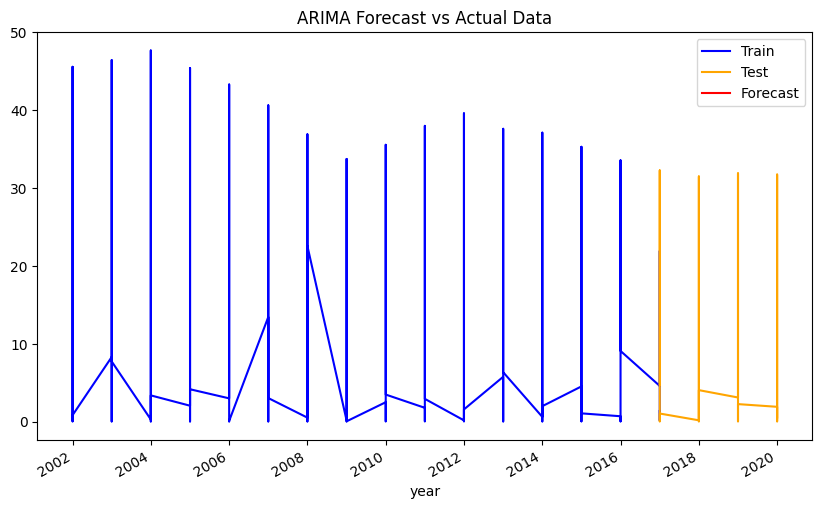

In [22]:
# Initialize and fit the AutoARIMA model
arima = pm.auto_arima(y_train, seasonal=False, stepwise=True)

# Forecast for the test data period
forecast = arima.predict(n_periods=len(y_test))

# Convert predictions to pandas Series with the same index as the test data
forecast = pd.Series(forecast, index=y_test.index)

# Print the forecasted values
print("ARIMA Forecast:")
print(forecast)

# Plot the actual data and the forecast
fig, ax = plt.subplots(figsize=(10, 6))
y_train.plot(ax=ax, label='Train', color='blue', legend=True)
y_test.plot(ax=ax, label='Test', color='orange', legend=True)
forecast.plot(ax=ax, label='Forecast', color='red', legend=True)
ax.set_title("ARIMA Forecast vs Actual Data")
plt.show()

In [23]:
# Select the target variable column (e.g., 'co2_emissions_per_capita')
y_train = data_with_dummies.loc[train_start:train_end, 'co2_emissions_per_capita']
y_test = data_with_dummies.loc[test_start:test_end, 'co2_emissions_per_capita']

# Initialize and fit the AutoARIMA model
arima = pm.AutoARIMA(seasonal=False)
arima.fit(y_train)

# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(y_test))

# Convert predictions to pandas Series with the same index as the train and test data
arima_train = pd.Series(arima_train, index=y_train.index)
arima_test = pd.Series(arima_test, index=y_test.index)

# Print the predicted values
print("ARIMA Train Predictions:", arima_train)
print("ARIMA Test Predictions:", arima_test)

# Plot the actual test data and the predictions
fig, ax = plt.subplots(figsize=(10, 6))
y_train.plot(ax=ax, label='Train', color='blue')
y_test.plot(ax=ax, label='Test', color='orange')
arima_test.plot(ax=ax, label='Predicted ARIMA', color='red')
ax.legend()
plt.show()

NameError: name 'data_with_dummies' is not defined

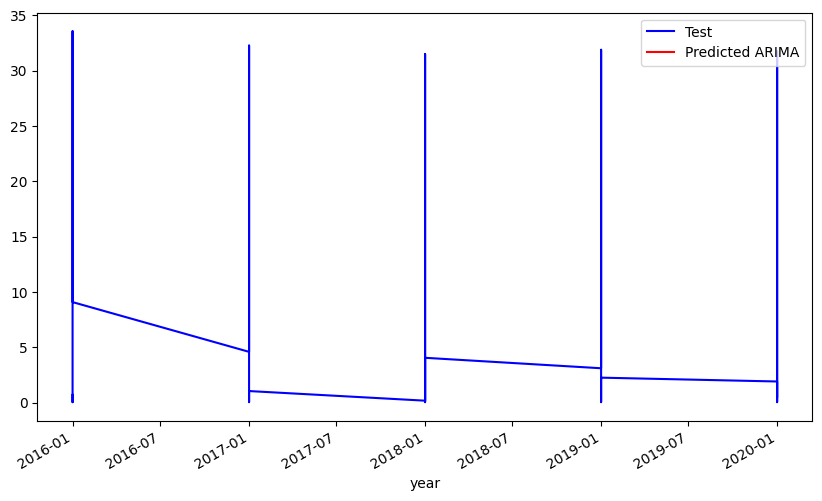

In [ ]:
# Plot the actual test data and the predictions
fig, ax = plt.subplots(figsize=(10, 6))
y_test.plot(ax=ax, label='Test', color='blue')
arima_test.plot(ax=ax, label='Predicted ARIMA', color='red')
ax.legend()
plt.show()

-------

In [ ]:
from sklearn.model_selection import TimeSeriesSplit 

tss = TimeSeriesSplit(n_splits=4)

lagged_data.set_index('year', inplace=True)
lagged_data.sort_index(inplace=True)

# Create lagged variables for CO2 emissions per capita
lagged_data['co2_emissions_per_capita_lag1'] = lagged_data.groupby('country')['co2_emissions_per_capita'].shift(1)
lagged_data['co2_emissions_per_capita_lag2'] = lagged_data.groupby('country')['co2_emissions_per_capita'].shift(2)

# Drop rows with NaN values created by lag features
lagged_data.dropna(inplace=True)

X = lagged_data.drop(labels=['co2_emissions_per_capita'], axis=1)
y = lagged_data['co2_emissions_per_capita']

NameError: name 'lagged_data' is not defined

In [ ]:
# train test split for a time series dataset
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Text(0.5, 1.0, 'Mean CO2 Emissions per Capita by Year')

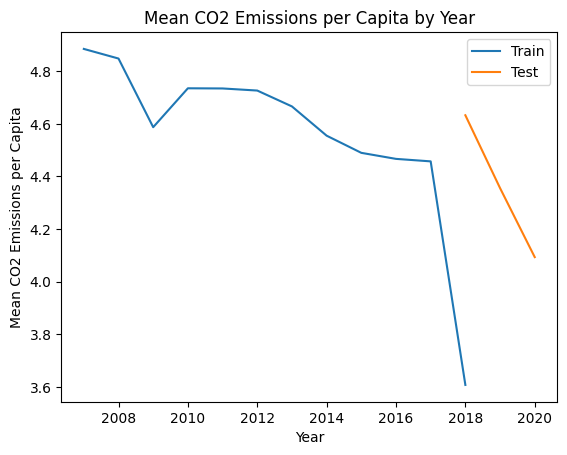

In [ ]:
# Plot the mean CO2 emissions per capita by year for train and test sets
y_train.groupby('year').mean().plot(label='Train', legend=True)
y_test.groupby('year').mean().plot(label='Test', legend=True)

plt.xlabel('Year')
plt.ylabel('Mean CO2 Emissions per Capita')
plt.title('Mean CO2 Emissions per Capita by Year')

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

ValueError: could not convert string to float: 'Hungary'

In [ ]:
# Forecasting the next 5 years
# Assuming you have the features for the next 5 years in X_future
# You need to create X_future with the same number of features as X_train

# Example: Creating a dummy X_future with the same number of features
# Replace this with your actual future data
num_features = X_train.shape[1]
X_future = np.random.rand(5, num_features)  # 5 future data points with the same number of features

# Ensure X_future is in the correct shape
X_future = X_future.reshape(-1, num_features)

y_future_pred = model.predict(X_future)
print(f'Forecasted CO2 Emissions per Capita for the next 5 years: {y_future_pred}')

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'